In [200]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import os
from IPython.display import display
import json
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

sns.set_style('whitegrid')

In [201]:
def read_csv_files_from_folder(folder_path):
    # Initialize an empty list to store DataFrames
    dfs = []
    # Get a list of files in the folder
    file_list = os.listdir(folder_path)
    # Iterate through the files in the folder
    for file_name in file_list:
        # Check if the file has a .csv extension
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Append the DataFrame to the list
            dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [202]:
results = read_csv_files_from_folder('ftl_sensibility_results/')

In [203]:
results.replace({'adult_dataset_reader': 'Adult Income', 'compas_dataset_reader': 'Compas Recidivism', 'german_dataset_reader': 'German Credit', 'bank_dataset_reader': 'Bank Marketing'}, inplace=True)

In [209]:
plot_metrics = ['protected_metrics_FNR', 'privileged_metrics_FNR', 'FNR', 'protected_metrics_FPR', 'privileged_metrics_FPR', 'FPR', 'protected_metrics_ACC', 'privileged_metrics_ACC', 'ACC' ]
plot_metrics_titles = ['Protected FNR', 'Privileged FNR', 'Overall FNR', 'Protected FPR', 'Privileged FPR', 'Overall FPR', 'Protected Accuracy', 'Privileged Accuracy', 'Overall Accuracy' ]
plot_metrics_map = {}
for m, t in zip(plot_metrics,plot_metrics_titles):
    plot_metrics_map[m] = t

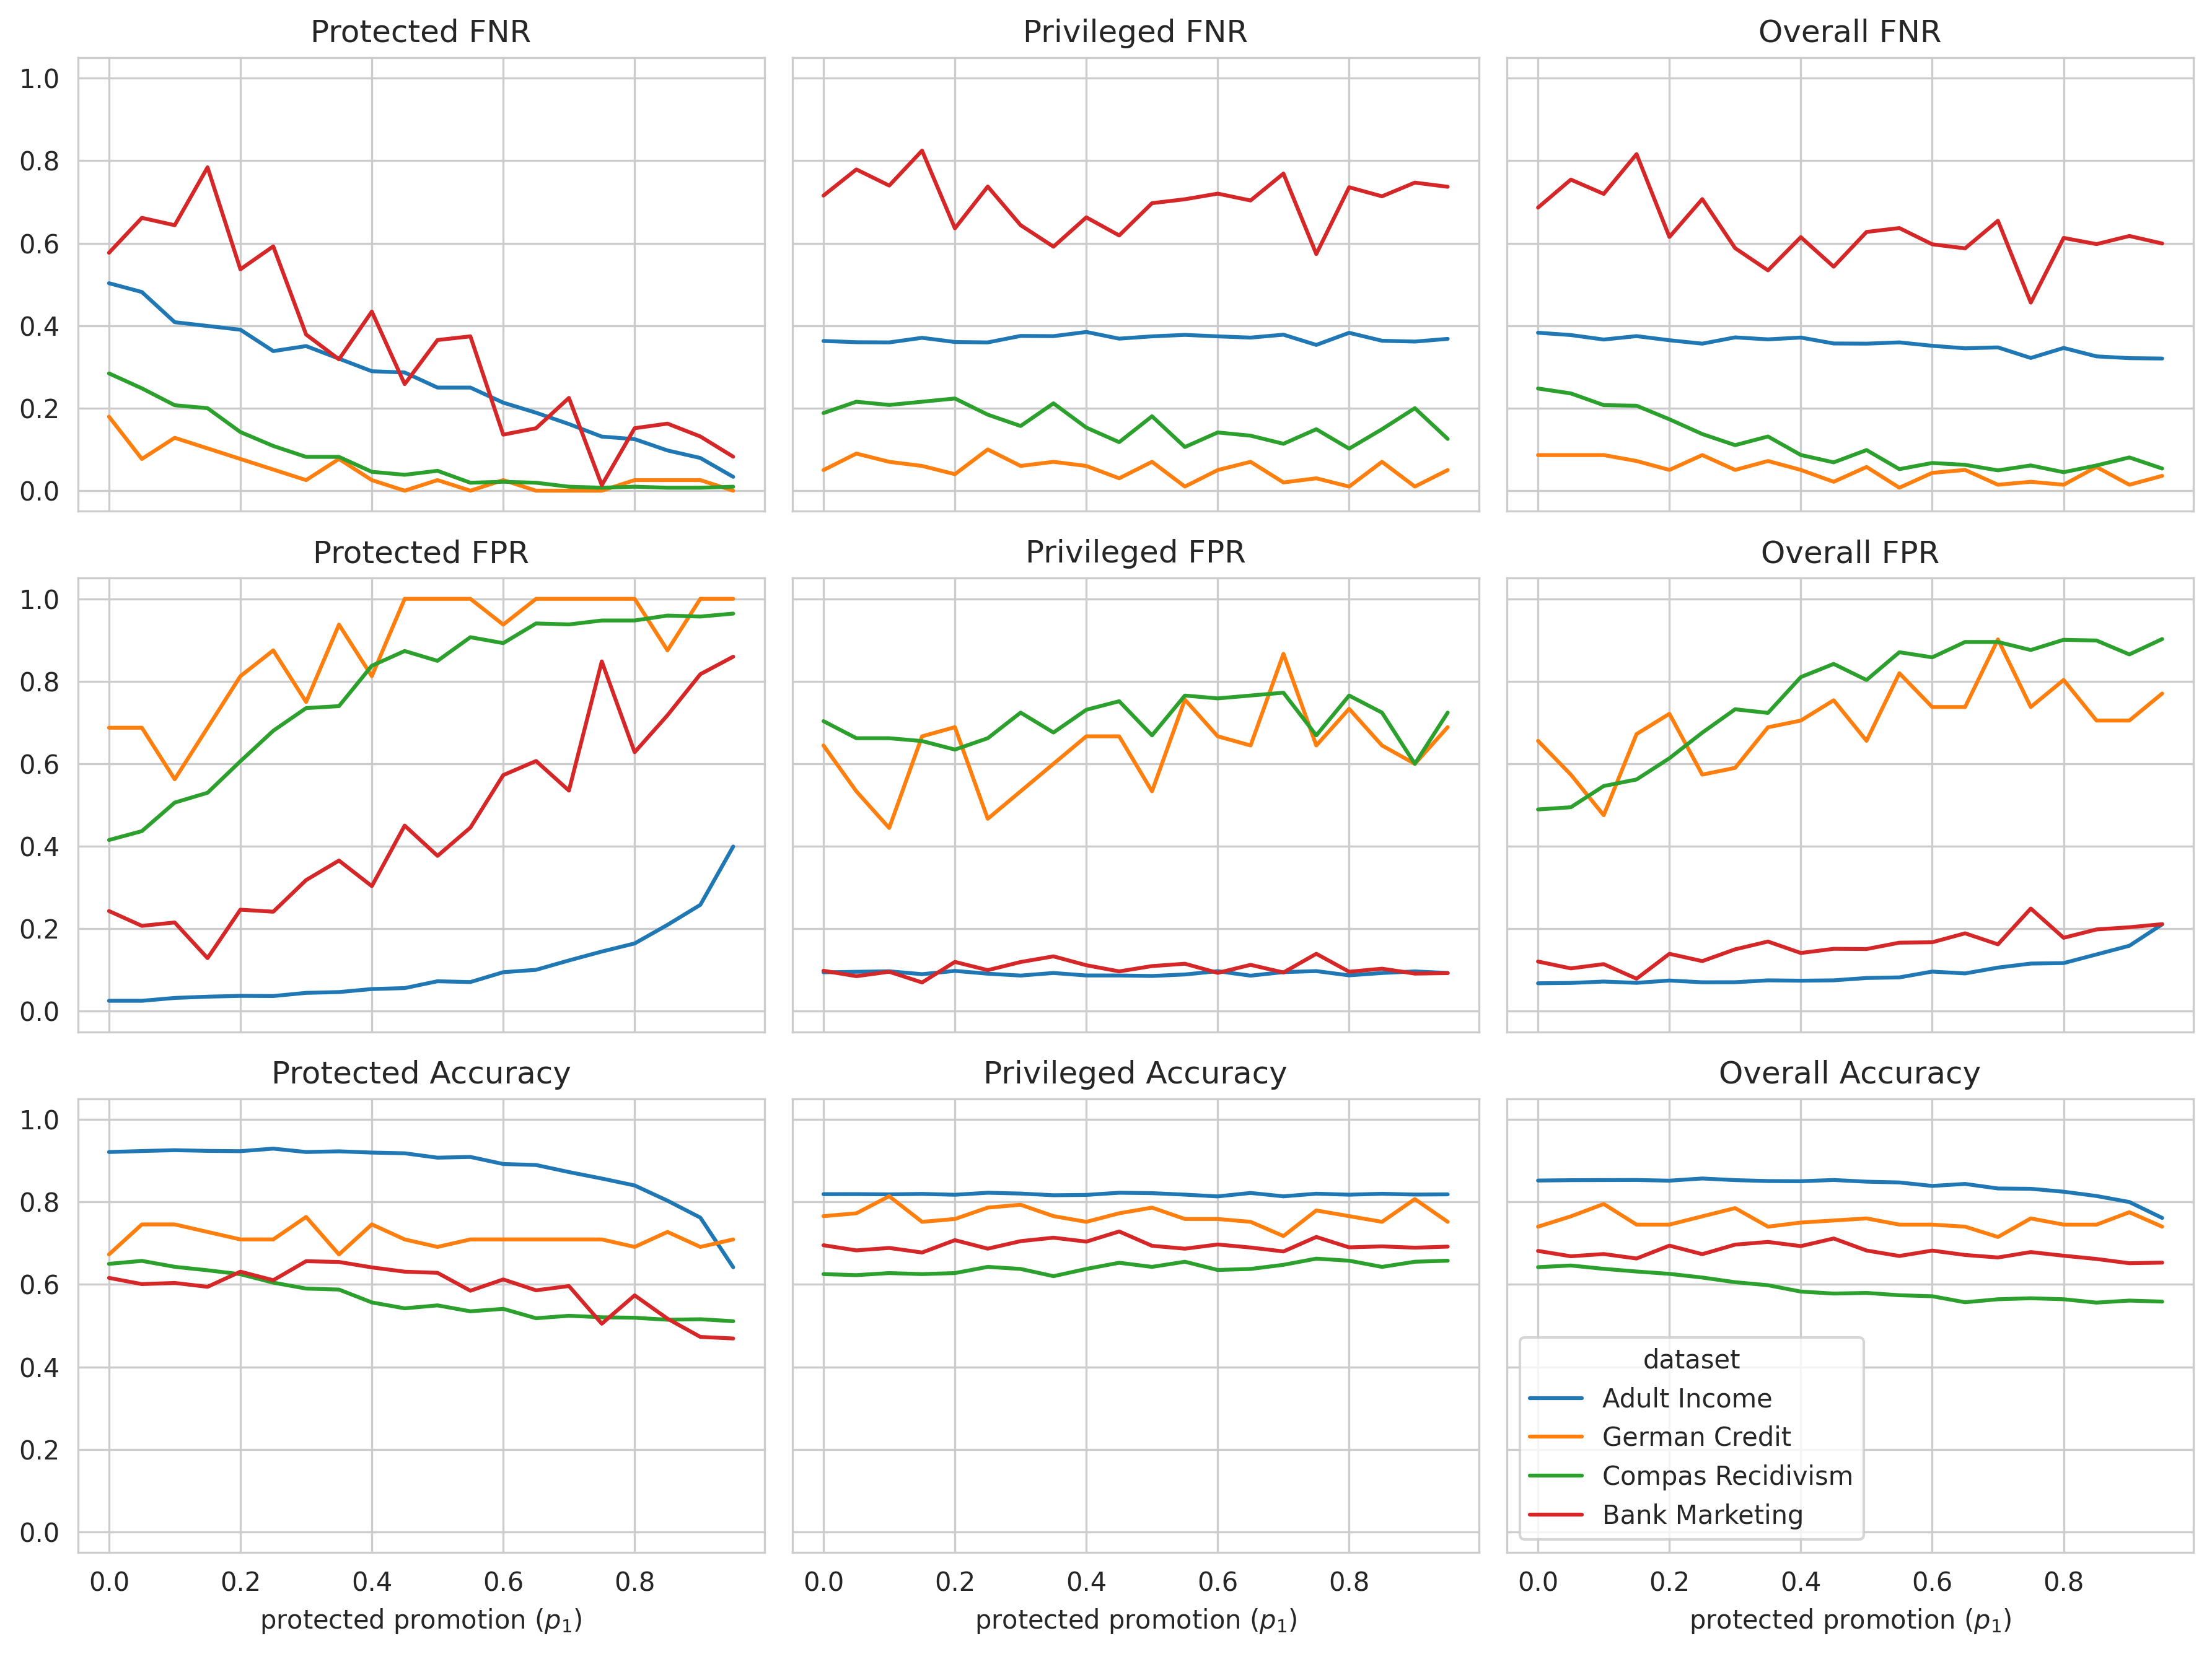

In [210]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9), sharex=True, sharey=True)
for metric, ax in zip(plot_metrics, axes.flatten()):
    if metric == 'ACC':
        sns.lineplot(data=results, x='protected_promotion', y=metric, hue='dataset', ax=ax)
    else:
        sns.lineplot(data=results, x='protected_promotion', y=metric, hue='dataset', ax=ax, legend=False)
    ax.set_xlabel('protected promotion ($p_1$)')
    ax.set_title(plot_metrics_map[metric])
    ax.set_ylabel('')
    
plt.tight_layout()
plt.savefig('sensibility_plots/ftl_sensibility_results.pdf')


In [ ]:
with open('fitness_sensibility_results/results_2024_01_08_10_55_44_619665.json') as file:
    json_results = json.load(file)

In [ ]:
fitness_rules = ['mcc_parity',
                'mcc_opportunity',
                'mcc_odds',
                'acc_parity',
                'acc_opportunity',
                'acc_odds'
]
fitness_rules_abvr = {
    'mcc_parity': 'Max(MCC - Stat. Parity)',
    'mcc_opportunity': 'Max(MCC - Eq. Odds)',
    'mcc_odds': 'Max(MCC - Eq. Opp.)',
    'acc_parity': 'Max(Acc - Stat. Parity)',
    'acc_opportunity': 'Max(Acc - Eq. Odds)',
    'acc_odds':  'Max(Acc - Eq. Opp.)'
}
fitness_rules_target_metrics = {
    'mcc_parity': ('MCC', 'stat_par_diff'),
    'mcc_opportunity': ('MCC', 'eq_opp_diff'),
    'mcc_odds': ('MCC', 'avg_odds_diff'),
    'acc_parity': ('ACC', 'stat_par_diff'),
    'acc_opportunity': ('ACC', 'eq_opp_diff'),
    'acc_odds': ('ACC', 'avg_odds_diff')
}

In [ ]:
results_dict = {}
for result in json_results:
    results_dict[result['fitness_rule']] = result

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), sharex='col', sharey='row')

for fitness_rule, ax in zip(fitness_rules, axes.flatten()):
    target_metrics = fitness_rules_target_metrics[fitness_rule]
    performance_metric, fairness_metric = target_metrics
    fitness_results = pd.DataFrame(results_dict[fitness_rule]['tune_results_history'])
    
    fitness_results['Performance'] = fitness_results[performance_metric]
    fitness_results['Fairness'] = fitness_results[fairness_metric]
    
    # Create a scatterplot without hue
    scatter = sns.scatterplot(data=fitness_results, x='Fairness', y='Performance', ax=ax, c=fitness_results['fitness'], cmap='coolwarm')
    ax.set_title(fitness_rules_abvr[fitness_rule])
    ax.set_xlabel('Fairness')
    ax.set_ylabel('Performance')
    
    # Create a ScalarMappable for the colorbar
    sm = cm.ScalarMappable(cmap='coolwarm')
    sm.set_array(fitness_results['fitness'])
    
    # Add a colorbar using the ScalarMappable
    cbar = plt.colorbar(sm, ax=ax)
    
    if ax in axes[:, -1]:
        cbar.set_label('Fitness')
    else:
        cbar.set_label('')
    
    if ax in axes[-1, :]:
        ax.set_xlabel('Fairness')
    else:
        ax.set_xlabel('') 
    
    if ax in axes[:, 0]:
        ax.set_ylabel('Performance')
    else:
        ax.set_ylabel('')  

    
plt.tight_layout()
plt.savefig('sensibility_plots/fitness_sensibility.pdf')
plt.show()